In [9]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
import json


In [10]:
with open('utils.py') as f:
    exec(f.read())


# Setup

In [11]:
median_income_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv"

training_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals.csv"

In [12]:
df = pd.read_csv(training_data_source)

# Clean Data
df = df[(df["Max Beds"] > 0 ) 
        & (df["Max Beds"] < 6)  
        & (df["Max Baths"] < 4)  
        & (df["Max Square Feet"] < 5000)  
        & (df["Max Rent Price"] < 10000)  
        & (df["State"].notna()) 
        & (df["Property Type"] == 6) 
        ]


df = df.rename(columns={
    'Max Square Feet': 'square_feet',
    'Max Beds': 'bedrooms',
    'Max Baths': 'bathrooms',
    'Max Rent Price': 'Rent',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})

basic_metadata = ["Property ID", "Address", "City", "State"]

basic_features = ["square_feet", "bedrooms", "bathrooms"]
target = "Rent"


# Get Median Income

In [13]:
cbg_geoid_col = 'cbg_geoid'  # Replace with the actual column name

df = get_median_income_data(df, cbg_geoid_col, median_income_data_source)

df = fill_null(df, columns_to_fill=['median_income'], method='median', groupby='State')

df = df.dropna(subset=basic_features)

# Feature Engineering

## One Hot Encoding

In [14]:
columns_to_encode = ['bedrooms', 'bathrooms']

# Apply one-hot encoding to the specified columns
df, one_hot_features = one_hot_encode_features(df, columns_to_encode, drop_first=True)

print("Encoded features:", one_hot_features)

Encoded features: ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bathrooms_1.0', 'bathrooms_1.5', 'bathrooms_2.0', 'bathrooms_2.5', 'bathrooms_3.0', 'bathrooms_3.5']


In [15]:
knn_features = ["latitude", "longitude"]
target = 'Rent'
n_values = [1, 5, 10]
save_location = r'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models'

# Apply the KNN benchmark function
df, benchmark_features = create_knn_benchmark_rent(df, knn_features, target, n_values, save_location)

print("Benchmark features created:", benchmark_features)

Benchmark features created: ['Rent_Benchmark_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Rent_Benchmark_10_neighbors']


## Recreate Features for Cross Validation

Cross-Validation R^2 Scores: [0.92285807 0.99500355 0.95297443 0.99476911 0.99002902]
Mean Cross-Validation R^2 Score: 0.9711
Cross-Validated Mean Absolute Error: 44.7867
Cross-Validated Median Absolute Error: 13.3436
Cross-Validated R^2 Score: 0.9694
Final Model Mean Absolute Error: 41.8063
Final Model Median Absolute Error: 13.1947
Final Model R^2 Score: 0.9753


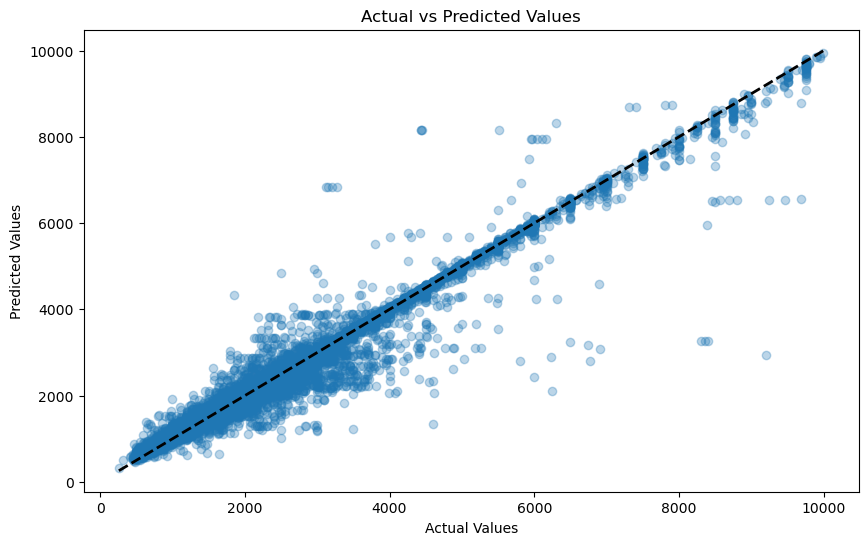

['C:\\Users\\mattl\\OneDrive\\Desktop\\Projects\\stoebebirch\\Models\\single_family_rent_predictor.joblib']

In [16]:
#Get Selected Features
with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

#Scale features and Generate Polynominals
potential_features = ["median_income"] + basic_features + one_hot_features + benchmark_features

X = scale_features(df[potential_features], mode='predict')
X, poly = generate_polynomial_features(X, original_feature_names= potential_features, mode='predict', degree=2)

#Create Training Set
X = pd.DataFrame(X, columns=poly)
X = X[selected_features]
y = df[target]

# Initialize the Linear Regression model
model = Ridge()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2 Score: {cv_scores.mean():.4f}")

# Get cross-validated predictions
cv_predictions = cross_val_predict(model, X, y, cv=5)

# Evaluate the model using cross-validated predictions
mae_cv = mean_absolute_error(y, cv_predictions)
r2_cv = r2_score(y, cv_predictions)
medae_cv = median_absolute_error(y, cv_predictions)  # Median Absolute Error

print(f"Cross-Validated Mean Absolute Error: {mae_cv:.4f}")
print(f"Cross-Validated Median Absolute Error: {medae_cv:.4f}")
print(f"Cross-Validated R^2 Score: {r2_cv:.4f}")

# Train the final model on the entire dataset
model.fit(X, y)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Add predictions to the original DataFrame
df['Predicted_Rent'] = predictions

df['Predicted_Rent'] = predictions

# Evaluate the final model
mae_final = mean_absolute_error(y, predictions)
r2_final = r2_score(y, predictions)
medae_final = median_absolute_error(y, predictions)  # Median Absolute Error

print(f"Final Model Mean Absolute Error: {mae_final:.4f}")
print(f"Final Model Median Absolute Error: {medae_final:.4f}")
print(f"Final Model R^2 Score: {r2_final:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, alpha=0.3)  # Adjust alpha for transparency
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()


# Save the final model to a file
joblib.dump(model, r'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models\single_family_rent_predictor.joblib')